<h1 style=\"text-align: center; font-size: 50px;\"> 🤖 Agentic RAG for AI Studio with TRT-LLM and LangGraph </h1>

# Imports

In [1]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations

# ─────── Standard Library ───────
import base64
import json
import logging
import os
import sys
import shutil
from pathlib import Path
import yaml
from typing import Any, Dict, List, Literal, Optional, TypedDict
from collections import namedtuple

# ─────── LangChain & Vector Store ───────
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import (
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

# ─────── Agent Framework & Messaging ───────
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# ─────── TRT-LLM ───────
import tensorrt_llm
parent_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_dir)
from src.trt_llm_langchain import TensorRTLangchain

# ─────── Observability & Display ───────
from IPython.display import display, HTML

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-02 00:56:31,360 - INFO - flashinfer.jit: Prebuilt kernels not found, using JIT backend


[TensorRT-LLM] TensorRT-LLM version: 0.18.0


# Configurations

In [3]:
TOPIC: str = "AI Studio"
CONTEXT_DIR: Path = Path("../data/context")             
CHROMA_DIR: Path = Path("../data/chroma_store")     
MEMORY_PATH: Path = Path("../data/memory/memory.json")     
MANIFEST_PATH: Path = CHROMA_DIR / "manifest.json"

In [4]:
LOG_FORMAT = "%(asctime)s [%(levelname)s] %(name)s: %(message)s"
LOG_DATEFMT = "%Y-%m-%d %H:%M:%S"

logging.basicConfig(
    level=logging.INFO,
    format=LOG_FORMAT,
    datefmt=LOG_DATEFMT,
)

# Named logger for the Agentic RAG notebook
logger = logging.getLogger("agentic_rag_notebook")

In [5]:
logger.info('Notebook execution started.')

2025-06-02 00:56:31 [INFO] agentic_rag_notebook: Notebook execution started.


# Memory Store

In [6]:
class SimpleKVMemory:
    """Very small persistent key-value store (JSON on disk)."""

    def __init__(self, file_path: Path) -> None:
        self.file_path: Path = file_path
        self._store: Dict[str, str] = self._load()

    # ---------- public ----------------------------------------------------
    def get(self, key: str) -> Optional[str]:
        """Return answer if present, else None."""
        return self._store.get(key)

    def set(self, key: str, value: str) -> None:
        """Save answer and flush to disk."""
        self._store[key] = value
        self._dump()

    # ---------- private ---------------------------------------------------
    def _load(self) -> Dict[str, str]:
        if self.file_path.exists():
            try:
                with self.file_path.open("r", encoding="utf-8") as f:
                    return json.load(f)
            except Exception as exc:  
                logger.warning("Failed to load memory (%s). Starting fresh.", exc)
        return {}

    def _dump(self) -> None:
        self.file_path.parent.mkdir(parents=True, exist_ok=True)
        with self.file_path.open("w", encoding="utf-8") as f:
            json.dump(self._store, f, ensure_ascii=False, indent=2)


memory: SimpleKVMemory = SimpleKVMemory(MEMORY_PATH)

# Retriever

In [7]:
# %pip install timm==1.0.13 --quiet

try:
    # Initialize the embedding model
    embed_model = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2",
        encode_kwargs={"normalize_embeddings": True},
    )
except:
    logger.info('First embedding model error was ignored.')
    # Initialize the embedding model again
    embed_model = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2",
        encode_kwargs={"normalize_embeddings": True},
    )

/tmp/ipykernel_1163/4247380489.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(
2025-06-02 00:56:31 [INFO] sentence_transformers.SentenceTransformer: Use pytorch device_name: cuda:0
2025-06-02 00:56:31 [INFO] sentence_transformers.SentenceTransformer: Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2


In [8]:
# Loader: try UnstructuredMarkdown, fallback to plain Text
def _load_markdown(path: Path) -> List[Document]:
    try:
        return UnstructuredMarkdownLoader(str(path)).load()
    except Exception:
        return TextLoader(str(path), encoding="utf-8").load()

# Compute a sorted list of all Markdown file paths (as strings)
def _current_manifest() -> List[str]:
    return sorted(str(p.resolve()) for p in CONTEXT_DIR.rglob("*.md"))

# Check whether we need to rebuild: manifest file missing or contents differ
def _needs_rebuild() -> bool:
    if not CHROMA_DIR.exists() or not MANIFEST_PATH.exists():
        return True
    try:
        old = json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    except Exception:
        return True
    return old != _current_manifest()

# Save the current manifest so future runs can compare
def _save_manifest(manifest: List[str]) -> None:
    CHROMA_DIR.mkdir(parents=True, exist_ok=True)
    MANIFEST_PATH.write_text(json.dumps(manifest, indent=2), encoding="utf-8")

# Build or load the Chroma vectorstore
def _build_vectorstore() -> Chroma:
    collection = "-".join(TOPIC.split())

    # If the manifest has changed, wipe & rebuild
    if _needs_rebuild():
        if CHROMA_DIR.exists():
            shutil.rmtree(CHROMA_DIR)
        logger.info("Building new Chroma index from Markdown files…")

        splitter = RecursiveCharacterTextSplitter(
            chunk_size=1024, chunk_overlap=128, add_start_index=True
        )
        docs: List[Document] = []

        for md_file in CONTEXT_DIR.rglob("*.md"):
            for page in _load_markdown(md_file):
                for chunk in splitter.split_documents([page]):
                    chunk.metadata.setdefault("source", md_file.name)
                    docs.append(chunk)

        chroma = Chroma.from_documents(
            docs,
            embedding=embed_model,
            collection_name=collection,
            persist_directory=str(CHROMA_DIR),
        )
        _save_manifest(_current_manifest())
        logger.info("Chroma index rebuilt with %d chunks.", len(docs))
        return chroma

    # Otherwise, load the existing, up-to-date index
    logger.info("Loading existing Chroma index from %s", CHROMA_DIR)
    return Chroma(
        collection_name=collection,
        persist_directory=str(CHROMA_DIR),
        embedding_function=embed_model,
    )

def retrieve(query: str, top_k: int = 5) -> List[str]:
    """Return the top-k most relevant Markdown chunks."""
    return [doc.page_content for doc in vectorstore.similarity_search(query, k=top_k)]

In [9]:
%%time

# Initialize once at import/run
vectorstore: Chroma = _build_vectorstore()

2025-06-02 00:56:35 [INFO] agentic_rag_notebook: Loading existing Chroma index from ../data/chroma_store
/tmp/ipykernel_1163/1836402453.py:60: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  return Chroma(
2025-06-02 00:56:35 [INFO] chromadb.telemetry.product.posthog: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


CPU times: user 464 ms, sys: 96.1 ms, total: 561 ms
Wall time: 1.82 s


# State Model

In [10]:
class RAGState(TypedDict, total=False):
    topic: str
    query: str
    is_relevant: Optional[bool]
    rewritten_query: Optional[str]
    retrieved_chunks: List[str]
    answer: Optional[str]
    from_memory: Optional[bool]
    messages: List[Dict[str, Any]]  # full conversation with LLM

# LLM Setup

In [11]:
sampling_params = tensorrt_llm.SamplingParams(
    temperature=0.0,        # Greedy decoding – no randomness
    top_k=1,                # Only the highest probability token is considered
    repetition_penalty=1.2, # Discourage redundant rambling
    stop_token_ids=[128009], # EOS token (from tokenizer config)
    max_tokens=4096,
)

In [12]:
%%time

MODEL_PATH = 'nvidia/Llama-3.1-Nemotron-Nano-8B-v1'

llm = TensorRTLangchain(
    model_path=MODEL_PATH, 
    sampling_params=sampling_params,
    build_engine=True,              # force-build now
    engine_save_path="."  # path where the .trt file goes
)

Loading Model: [1/3]	Downloading HF model
Downloaded model to /root/.cache/huggingface/hub/models--nvidia--Llama-3.1-Nemotron-Nano-8B-v1/snapshots/a22e1c57330633cd3522903f9bb82480bf3192a6
Time: 122.264s
Loading Model: [2/3]	Loading HF model to memory
230it [00:00, 943.65it/s]
Time: 0.732s
Loading Model: [3/3]	Building TRT-LLM engine
Time: 63.286s
Loading model done.
Total latency: 186.283s
2025-06-02 01:00:11,474 - INFO - flashinfer.jit: Prebuilt kernels not found, using JIT backend


[TensorRT-LLM] TensorRT-LLM version: 0.18.0
[TensorRT-LLM][INFO] Engine version 0.18.0 found in the config file, assuming engine(s) built by new builder API.
[TensorRT-LLM][INFO] Refreshed the MPI local session
[TensorRT-LLM][INFO] MPI size: 1, MPI local size: 1, rank: 0
[TensorRT-LLM][INFO] Rank 0 is using GPU 0
[TensorRT-LLM][WARNING] Fix optionalParams : KV cache reuse disabled because model was not built with paged context FMHA support
[TensorRT-LLM][INFO] TRTGptModel maxNumSequences: 2048
[TensorRT-LLM][INFO] TRTGptModel maxBatchSize: 2048
[TensorRT-LLM][INFO] TRTGptModel maxBeamWidth: 1
[TensorRT-LLM][INFO] TRTGptModel maxSequenceLen: 131072
[TensorRT-LLM][INFO] TRTGptModel maxDraftLen: 0
[TensorRT-LLM][INFO] TRTGptModel mMaxAttentionWindowSize: (131072) * 32
[TensorRT-LLM][INFO] TRTGptModel enableTrtOverlap: 0
[TensorRT-LLM][INFO] TRTGptModel normalizeLogProbs: 0
[TensorRT-LLM][INFO] TRTGptModel maxNumTokens: 8192
[TensorRT-LLM][INFO] TRTGptModel maxInputLen: 8192 = min(maxSeque

In [13]:
Response = namedtuple("Response", ["content"])

def get_response_from_llm(llm, system_prompt, user_prompt):
    meta_llama_prompt = f'''
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    
    {system_prompt}<|eot_id|><|start_header_id|>user<|end_header_id|>
    
    {user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
    '''
    return Response(content=llm(meta_llama_prompt))

# Node Functions

In [14]:
def ingest_query(state: RAGState) -> Dict[str, Any]:
    """
    Log the incoming user query and record it in the message history.
    """
    user_query = state["query"]
    logger.info("Received user query: %s", user_query)
    previous_messages = state.get("messages", [])
    new_messages = previous_messages + [{"role": "user", "content": user_query}]
    return {"messages": new_messages}


def check_relevance(state: RAGState) -> Dict[str, Any]:
    """
    Ask the LLM whether the query relates to our topic.
    If not relevant, include a default apology answer.
    """
    topic = state["topic"]
    user_query = state["query"]
    
    system_prompt = (
        "You are a strict classifier. Only respond with either \"yes\" or \"no\". "
        "Do not include any additional words, explanations, or punctuation. "
        "Answer based solely on whether the user's query is about the specified topic."
    )
    
    user_prompt = (
        f"The topic is: \"{topic}\"\n\n"
        f"User query: \"{user_query}\"\n\n"
        "Is this query related to the topic above? Respond with only 'yes' or 'no'."
        "Answer: "
    )
    
    response = get_response_from_llm(llm, system_prompt, user_prompt)

    is_relevant = "yes" in response.content.strip().lower()
    logger.info("Relevance check result: %s", is_relevant)

    messages = state.get("messages", []) + [
        {"role": "developer", "content": 'Relevance check result:'},
        {"role": "assistant", "content": response.content}
    ]
    result: Dict[str, Any] = {"is_relevant": is_relevant, "messages": messages}

    if not is_relevant:
        result["answer"] = (
            f"Sorry, I can only answer questions related to {topic}."
        )
    return result


def check_memory(state: RAGState) -> Dict[str, Any]:
    """
    Look up the exact user query in memory and return the cached answer if found.
    """
    raw_query = state["query"]
    key = raw_query.strip().lower()
    cached_answer = memory.get(key)
    if cached_answer is not None:
        logger.info("Cache hit for query: %s", raw_query)
        return {"answer": cached_answer, "from_memory": True}
    logger.info("Cache miss for query: %s", raw_query)
    return {"from_memory": False}


def rewrite_query(state: RAGState) -> Dict[str, Any]:
    """
    Correct any grammar in the question and rewrite it as a clear statement
    without altering its meaning, to improve retrieval.
    """
    original = state["query"]
    
    system_prompt = (
        "You are a rewriting assistant. Your only task is to convert a question into a "
        "grammatically correct statement. Do not change its meaning. "
        "Output only the corrected statement—no explanations or extra text."
    )
    
    user_prompt = (
        "Convert the following question into a grammatically correct statement "
        "that preserves the original meaning exactly:\n\n"
        "Note: Output only the corrected statement—no explanations or extra text."
        f"Question: \"{original}\"\n\n"
        "Corrected Statement:"
    )
        
    response = get_response_from_llm(llm, system_prompt, user_prompt)

    rewritten = response.content.strip()
    logger.info("Rewritten query: %s", rewritten)

    messages = state.get("messages", []) + [
        {"role": "developer", "content": 'Rewritten query: '},
        {"role": "assistant", "content": rewritten}
    ]
    return {"rewritten_query": rewritten, "messages": messages}


def retrieve_chunks(state: RAGState) -> Dict[str, Any]:
    """
    Fetch the top-k most relevant chunks for the rewritten query.
    """
    statement = state["rewritten_query"]
    chunks = retrieve(statement)
    logger.info("Retrieved %d chunks for query.", len(chunks))
    return {"retrieved_chunks": chunks}


def generate_answer(state: RAGState) -> Dict[str, Any]:
    """
    Use the LLM to generate an answer based solely on retrieved context.
    """
    topic = state["topic"]
    user_query = state["query"]
    context = "\n\n---\n\n".join(state["retrieved_chunks"])
    
    system_prompt = (
        f"You are a knowledgeable assistant specialized in {topic}. Your task is to answer "
        "the user query using only the information found within the <context> block. "
        "Ignore any external knowledge. If the context does not contain the answer, reply exactly with: \"I don't know.\" "
        "Do not assume, infer, or add any extra information. "
        "Respond with only the answer—do not include any introductory or explanatory text."
    )
    
    user_prompt = (
        f"<context>\n{context}\n</context>\n\n"
        f"User query: \"{user_query}\"\n\n"
        "Based only on the context above, provide the exact answer to the query. "
        "If the context does not contain the answer, respond exactly with: \"I don't know.\" "
        "Give only the answer—do not include any intro phrases such as 'The answer is' or 'Here it is'."
        "Use all relevant contextual information to provide a thorough, comprehensive answer to the user’s question."
        "Answer: "
    )


    response = get_response_from_llm(llm, system_prompt, user_prompt)

    answer = response.content.strip()
    logger.info("Generated answer (%d chars)", len(answer))

    messages = state.get("messages", []) + [
        {"role": "developer", "content": 'Generated answer: '},
        {"role": "assistant", "content": answer}
    ]
    return {"answer": answer, "messages": messages}


def update_memory(state: RAGState) -> Dict[str, Any]:
    """
    Store new query-answer pairs in memory for faster future lookup.
    """
    if state.get("from_memory"):
        return {}
    raw_query = state["query"]
    key = raw_query.strip().lower()
    memory.set(key, state["answer"])
    logger.info("Stored query-answer in memory for key: %s", key)
    return {}


def output_answer(state: RAGState) -> Dict[str, Any]:
    """
    Present the final answer to the user (e.g., print or API response).
    """
    print("\n=== Answer ===\n", state["answer"], "\n==============\n")
    return {}

# Graph Definition

In [15]:
def route_relevance(state: RAGState) -> Literal["irrelevant", "relevant"]:
    return "relevant" if state["is_relevant"] else "irrelevant"


def route_memory(state: RAGState) -> Literal["cached", "not_cached"]:
    return "cached" if state.get("from_memory") else "not_cached"


rag_graph = StateGraph(RAGState)

# Nodes
rag_graph.add_node("ingest_query", ingest_query)
rag_graph.add_node("check_relevance", check_relevance)
rag_graph.add_node("rewrite_query", rewrite_query)
rag_graph.add_node("check_memory", check_memory)
rag_graph.add_node("retrieve_chunks", retrieve_chunks)
rag_graph.add_node("generate_answer", generate_answer)
rag_graph.add_node("update_memory", update_memory)
rag_graph.add_node("output_answer", output_answer)

# Edges
rag_graph.add_edge(START, "ingest_query")
rag_graph.add_edge("ingest_query", "check_relevance")

rag_graph.add_conditional_edges(
    "check_relevance",
    route_relevance,
    {
        "irrelevant": "output_answer",      
        "relevant": "check_memory",
    },
)

rag_graph.add_conditional_edges(
    "check_memory",
    route_memory,
    {
        "cached": "output_answer",
        "not_cached": "rewrite_query",
    },
)

rag_graph.add_edge("rewrite_query", "retrieve_chunks")
rag_graph.add_edge("retrieve_chunks", "generate_answer")
rag_graph.add_edge("generate_answer", "update_memory")
rag_graph.add_edge("update_memory", "output_answer")
rag_graph.add_edge("output_answer", END)

compiled_graph = rag_graph.compile()

# Graph Visualization

In [16]:
def display_image(image_bytes: bytes, width=400):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))


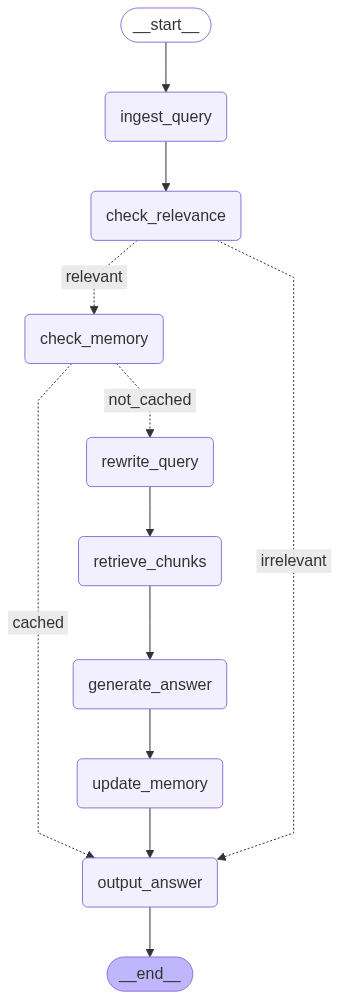

In [17]:
png = compiled_graph.get_graph().draw_mermaid_png()
display_image(png)

# Generated Answer

In [18]:
%%time

final_graph = compiled_graph.invoke(
        input={
            "topic": TOPIC,
            "query": 'How to create a project in ai studio',
            "messages": [],
        },
    )

            # "query": 'What is AI Studio?',
            # "query": 'What are the technical requiemetns of ai studi',
            # "query": 'How to create a project in ai studio',
            # "query": 'How can i create a workspace in ai studio',
            # "query": 'how can i use ai studio',

2025-06-02 01:00:22 [INFO] agentic_rag_notebook: Received user query: How to create a project in ai studio
/tmp/ipykernel_1163/3637913627.py:11: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return Response(content=llm(meta_llama_prompt))
Processed requests:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/tensorrt_llm/llmapi/utils.py:412: UserWarning: LLM API is running in async mode because you have a running event loop, but you are using sync API. This may lead to potential performance loss.
  warnings.warn(
Processed requests: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]
2025-06-02 01:00:25 [INFO] agentic_rag_notebook: Relevance check result: True
2025-06-02 01:00:25 [INFO] agentic_rag_notebook: Cache miss for query: How to create a project in ai studio
Processed requests:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-pack


=== Answer ===
 Select New Project From the Projects Home Page; enter a name and optional description, followed by choosing a privacy setting. Then pick an associated Git repo and specify a local folder to store your project's code. Click Continue once done. Add relevant tags to facilitate collaboration among team members. Click Create Workspace to save your new workspace. Choose a workspace template and click Create Project. 

CPU times: user 626 ms, sys: 144 ms, total: 771 ms
Wall time: 6.34 s


# Retrieved Context

In [19]:
final_graph.get('retrieved_chunks')

['Software:\n\nWindows 10 or 11 or Linux Ubuntu 22.04 LTS\n\nWindows OS requires Windows Subsystem for Linux (WSL). AIS installs WSL if not present.\n\nGit is required for github cloning, but not a requirement to use the app.\n\nInternet access is required for downloading container images and for web syncing of project metadata.\n\nCreating Your First AI Studio Project\n\nProjects are the main concept AI Studio is built around. They should be used to house all the information needed for someone to recreate a data science experiment, model training or data processing activity. To do this you will need to make a few changes to the way you may normally develop but the benefits are that when you are coming back to a project at a later date, handing off work or onboarding a new team member the setup time for that new person to continue from where you left off should be basically instant.\n\nCreate the Project',
 "title: 'Navigating the Projects Page' sidebar_position: 1\n\nNavigating the Pr

# Message History

In [20]:
final_graph.get('messages')

[{'role': 'user', 'content': 'How to create a project in ai studio'},
 {'role': 'developer', 'content': 'Relevance check result:'},
 {'role': 'assistant', 'content': ' yes'},
 {'role': 'developer', 'content': 'Rewritten query: '},
 {'role': 'assistant',
  'content': 'To create a project in AI Studio, follow these steps.'},
 {'role': 'developer', 'content': 'Generated answer: '},
 {'role': 'assistant',
  'content': "Select New Project From the Projects Home Page; enter a name and optional description, followed by choosing a privacy setting. Then pick an associated Git repo and specify a local folder to store your project's code. Click Continue once done. Add relevant tags to facilitate collaboration among team members. Click Create Workspace to save your new workspace. Choose a workspace template and click Create Project."}]

In [21]:
logger.info('Notebook execution completed.')

2025-06-02 01:00:28 [INFO] agentic_rag_notebook: Notebook execution completed.
